In [66]:
import itertools
import os
import json
import time
from datetime import datetime
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Reproducebality 
torch.manual_seed(0)
np.random.seed(0)

In [55]:
torch.backends.mps.is_available()

True

In [56]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Load custom MNIST dataset from folders
train_dataset = datasets.ImageFolder(
    root='./MNIST-full/train',  # Path to training data
    transform=transform
)

test_dataset = datasets.ImageFolder(
    root='./MNIST-full/test',   # Path to test data
    transform=transform
)

In [57]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


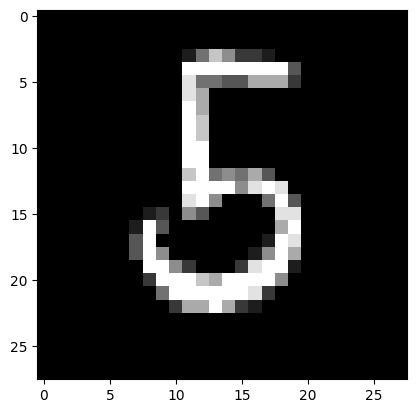

Label: 5


In [59]:
# Get a batch of data
train_features, train_labels = next(iter(train_dataloader))

# Print shapes
print(f"Feature batch shape: {train_features.size()}")  # [batch_size, channels, height, width]
print(f"Labels batch shape: {train_labels.size()}")     # [batch_size]

# Show the first image
img = train_features[0].squeeze()  # Remove channel dim (since MNIST is grayscale)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label.item()}")  # .item() to get the Python number from the tensor

In [72]:
# Define CNN model
class CNN(nn.Module):
    def __init__(self, kernel_sizes=[3, 3], num_channels=[32, 64]):
        super(CNN, self).__init__()
        self.features = nn.Sequential()
        in_channels = 1
        
        # Dynamically calculate spatial dimensions
        spatial_size = 28  # MNIST initial size
        
        # Build convolutional layers
        for i, (k, out_channels) in enumerate(zip(kernel_sizes, num_channels)):
            self.features.add_module(f'conv_{i}', nn.Conv2d(in_channels, out_channels, 
                                                         kernel_size=k, padding=k//2))
            self.features.add_module(f'relu_{i}', nn.ReLU())
            self.features.add_module(f'pool_{i}', nn.MaxPool2d(2))
            
            # Update spatial dimensions
            spatial_size = spatial_size // 2  # MaxPool2d reduces by 2
            in_channels = out_channels
        
        # Calculate final flattened size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 28, 28)
            dummy_output = self.features(dummy_input)
            self.flattened_size = dummy_output.numel() // dummy_output.size(0)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [61]:
# Create dirs if they don't exist
os.makedirs('cnn', exist_ok=True)
os.makedirs('cnn/models', exist_ok=True)
os.makedirs('cnn/plots', exist_ok=True)

In [62]:
# Define hyperparameter search space
param_grid = {
    'kernel_sizes': [[3, 3], [5, 5], [7, 7]],
    'num_layers': [1, 2],
    'learning_rate': [1e-1, 1e-2, 1e-3, 1e-4],
    'num_epochs': [5]
}

# Generate all combinations
keys = param_grid.keys()
values = param_grid.values()
param_combinations = [dict(zip(keys, combo)) for combo in itertools.product(*values)]

print(f"Total combinations to test: {len(param_combinations)}")

Total combinations to test: 24


In [63]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [82]:
import matplotlib.pyplot as plt
from pathlib import Path

def train_evaluate(params, trial_num, best_model_info, log_file='cnn/logs.txt'):

    # Model setup
    num_channels = [32] * params['num_layers']
    model = CNN(kernel_sizes=params['kernel_sizes'], num_channels=num_channels)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    
    # Training tracking
    train_losses = []
    val_accuracies = []
    train_accuracies = []
    best_val_acc = 0
    
    log_header = f"\n{'='*60}\nTrial {trial_num} | {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n"
    log_header += f"Params: {params}\n"
    log_header += f"{'Epoch':<7} | {'Train Loss':<12} | {'Train Acc':<10} | {'Val Acc':<8} | {'Time':<8}\n"
    log_header += f"{'-'*7}+{'-'*13}+{'-'*11}+{'-'*9}+{'-'*8}\n"
    
    print(log_header)
    with open(log_file, 'a') as f:
        f.write(log_header)

    # Training loop
    for epoch in range(params['num_epochs']):
        start_time = time.time()
        
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        
        for images, labels in train_dataloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        avg_loss = epoch_loss / len(train_dataloader)
        train_acc = 100 * correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(train_acc)
        
        # Using test as val
        val_acc = evaluate(model, test_dataloader)  
        val_accuracies.append(val_acc)
        
        # Track best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
        
        # Log entry
        epoch_time = time.time() - start_time
        log_entry = (f"{epoch+1:>4}/{params['num_epochs']} | {avg_loss:>10.4f} | "
                    f"{train_acc:>8.2f}% | {val_acc:>6.2f}% | {epoch_time:>4.1f}s\n")
        
        print(log_entry, end='')
        with open(log_file, 'a') as f:
            f.write(log_entry)
    
    # Final evaluation
    test_acc = evaluate(model, test_dataloader)
    
    # Update best model
    if best_model_info is None or test_acc > best_model_info['test_accuracy']:
        best_model_info = {
            'params': params,
            'test_accuracy': test_acc,
            'model_state': model.state_dict(),
            'trial_num': trial_num,
            'log_file': log_file,
            'train_history': {  # Store all metrics for plotting
                'train_loss': train_losses,
                'train_acc': train_accuracies,
                'val_acc': val_accuracies
            }
        }
        torch.save(model.state_dict(), "cnn/models/best_model.pth")
    
    # Save plots for this trial
    plot_trial_results(trial_num,
                       params,
                       train_losses,
                       train_accuracies,
                       val_accuracies,
                       save_dir=Path(log_file).parent)
    
    log_footer = f"{'='*60}\n"
    log_footer += f"Trial {trial_num} Complete | Best Val Acc: {best_val_acc:.2f}% | Test Acc: {test_acc:.2f}%\n"
    log_footer += f"{'='*60}\n"
    
    print(log_footer)
    with open(log_file, 'a') as f:
        f.write(log_footer)
    
    return best_model_info

# Plot and save training curves for a single trial
def plot_trial_results(trial_num, params, train_loss, train_acc, val_acc, save_dir):
    plt.figure(figsize=(12, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, 'b-', label='Training Loss')
    plt.title(f'Trial {trial_num}: Training Loss\n{params_str(params)}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, 'g-', label='Train Accuracy')
    plt.plot(val_acc, 'r-', label='Val Accuracy')
    plt.title(f'Trial {trial_num}: Accuracy\n{params_str(params)}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plot_path = f'cnn/plots/trial_{trial_num}_curves.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved training curves to: {plot_path}")

# Format parameters for plot titles
def params_str(params):
    return (f"KS={params['kernel_sizes']}, "
            f"LR={params['learning_rate']:.0e}, "
            f"Layers={params['num_layers']}")

In [83]:
# Initialize log file
with open("cnn/logs.txt", 'w') as f:
    f.write("Hyperparameter Optimization Log\n")
    f.write(f"Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("="*60 + "\n")

In [84]:
## Note - Takes 75 mins to run on a local macbook
best_model = None
for i, params in enumerate(param_combinations, 1):
    best_model = train_evaluate(params, i, best_model)

# Final results
final_log = "\n=== FINAL RESULTS ===\n"
final_log += f"Best model from Trial {best_model['trial_num']}\n"
final_log += f"Test Accuracy: {best_model['test_accuracy']:.2f}%\n"
final_log += f"Parameters: {best_model['params']}\n"
final_log += f"Detailed logs saved to: {best_model['log_file']}\n"

print(final_log)
with open("cnn/logs.txt", 'a') as f:
    f.write(final_log)


Trial 1 | 2025-04-04 20:02:17
Params: {'kernel_sizes': [3, 3], 'num_layers': 1, 'learning_rate': 0.1, 'num_epochs': 5}
Epoch   | Train Loss   | Train Acc  | Val Acc  | Time    
-------+-------------+-----------+---------+--------

   1/5 |     2.3876 |    45.19% |  71.15% | 23.4s
   2/5 |     1.7077 |    39.02% |   9.80% | 22.8s
   3/5 |     2.3093 |    10.36% |  10.10% | 22.9s
   4/5 |     2.3099 |    10.19% |  10.10% | 23.0s
   5/5 |     2.3107 |    10.13% |   9.82% | 22.7s
Saved training curves to: cnn/plots/trial_1_curves.png
Trial 1 Complete | Best Val Acc: 71.15% | Test Acc: 9.82%


Trial 2 | 2025-04-04 20:04:13
Params: {'kernel_sizes': [3, 3], 'num_layers': 1, 'learning_rate': 0.01, 'num_epochs': 5}
Epoch   | Train Loss   | Train Acc  | Val Acc  | Time    
-------+-------------+-----------+---------+--------

   1/5 |     0.2977 |    92.81% |  97.34% | 23.5s
   2/5 |     0.0784 |    97.64% |  97.91% | 22.7s
   3/5 |     0.0636 |    98.08% |  97.44% | 22.5s
   4/5 |     0.0584 |

In [85]:
print("\n=== Best Model ===")
print(f"Trial: {best_model['trial_num']}")
print(f"Test Accuracy: {best_model['test_accuracy']:.2f}%")
print(f"Parameters: {best_model['params']}")


=== Best Model ===
Trial: 15
Test Accuracy: 99.11%
Parameters: {'kernel_sizes': [5, 5], 'num_layers': 2, 'learning_rate': 0.001, 'num_epochs': 5}
